# Import Library

In [1]:
import snowballstemmer
import sparse_dot_topn.sparse_dot_topn as ct
from wordcloud import WordCloud, ImageColorGenerator
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from scipy.sparse import csr_matrix

import re
import string
import random
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
import time
import random
import os
from nltk.tokenize import word_tokenize

# 1. Import Data

In [2]:
data = pd.read_csv('data_ekspor.csv', delimiter = "|")

In [3]:
data.shape

(209841, 1)

In [4]:
data.head()

,RINCIAN_BARANG
0,BAGIAN RACK DARI KAYU ALBASIA DAN MDF
1,"LG,MD,SM RD BANANA BSKT NATXL,L,M,S BANANA BAR..."
2,INDONESIAN HARDWOOD PLYWOOD8.5 MM X 910MM X 18...
3,FURNITURE ROTAN FULL
4,BENCH


# 2. Data Cleansing

In [5]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

#the stemmer requires a language parameter
 
def StemmerProcess(text):
    text = stemmer.stem(text)
    
    return text

# Fungsi yang digunakan untuk cleansing data text
def RegexSub(text):
    # case folding
    text = text.lower()

    # regex untuk menghilangkan punctuation
    text = re.sub(r'\W+', ' ', text)

    # regex untuk menghilangkan angka 
    text = re.sub(r'[0-9]{1,9}', ' ', text)

    # regex untuk menghilangkan kata USER 
    text = re.sub(r'user', ' ', text)

    # regex untuk menghilangkan kata/token yang terdiri dari 1-2 huruf
    text = re.sub(r'\b\w{1,2}\b', ' ', text)

    # regex untuk menghilangkan space/whitespace yang >2
    text = re.sub(r'\s{2,}', ' ', text)

    # memastikan untuk menghilangkan whitespace di akhir text
    text = text.strip()

    return text

# Fungsi untuk membuat ngram, dimana jumlah window defaultnya adalah 2 (bigram)
def NgramsTokenizer(text, num=2):
    # tokenize ngram 
    n_grams = ngrams(nltk.word_tokenize(text), num)
    # mengembalikan list text menjadi text kembali
    final_text = [' '.join(grams) for grams in n_grams]
    return final_text

# Funsi untuk process stemmer
def StemmerProcess(text):
    text = stemmer.stem(text)
    return text

## Pre-Processing

In [6]:
# cleansing data tweet, dan hasil cleansing distore ke dalam kolom baru ke 'tweet_regex'
data['filtered_text'] = data['RINCIAN_BARANG'].apply(RegexSub)
data.head()

,RINCIAN_BARANG,filtered_text
0,BAGIAN RACK DARI KAYU ALBASIA DAN MDF,bagian rack dari kayu albasia dan mdf
1,"LG,MD,SM RD BANANA BSKT NATXL,L,M,S BANANA BAR...",banana bskt natxl banana bark round verticalli...
2,INDONESIAN HARDWOOD PLYWOOD8.5 MM X 910MM X 18...,indonesian hardwood plywood
3,FURNITURE ROTAN FULL,furniture rotan full
4,BENCH,bench


In [7]:
stemmer = snowballstemmer.stemmer('indonesian')

with tqdm(total=data.shape[0]) as pbar:
    for index,row in data.iterrows():
        new_text = stemmer.stemWords(row['filtered_text'].split())
        new_text = ' '.join([word for word in new_text])
        row['filtered_text'] = new_text
        pbar.update(1)

100%|███████████████████████████████████████████████████████████| 209841/209841 [00:44<00:00, 4713.88it/s]


In [8]:
data.head()

,RINCIAN_BARANG,filtered_text
0,BAGIAN RACK DARI KAYU ALBASIA DAN MDF,bagi rack dari kayu albasia dan mdf
1,"LG,MD,SM RD BANANA BSKT NATXL,L,M,S BANANA BAR...",banana bskt natxl banana bark round verticalli...
2,INDONESIAN HARDWOOD PLYWOOD8.5 MM X 910MM X 18...,indonesi hardwood plywood
3,FURNITURE ROTAN FULL,furniture rotan full
4,BENCH,bench


In [9]:
data.shape

(209841, 2)

## Common Word

In [10]:
data['temp_list'] = data['filtered_text'].apply(lambda x:str(x).split())

In [11]:
res = {}
for words in data['temp_list']:
    for word in words:
        if word not in res:
            res[word] = 1
        else:
            res[word] += 1

df_common_word_pos = pd.DataFrame(res.items(), columns=['word', 'count']).sort_values(by='count',ascending=False).reset_index(drop=True).iloc[:20]
df_common_word_pos.style.background_gradient(cmap='Blues')

,word,count
0,plywood,38897
1,indonesi,30937
2,door,21252
3,mdf,12606
4,and,12348
5,mmx,12030
6,board,10952
7,wood,10426
8,kayu,9720
9,wooden,9443


In [12]:
temp_res = []
for words in data['temp_list']:
    temp_words = ' '.join(words)
    temp_res.append(temp_words)  

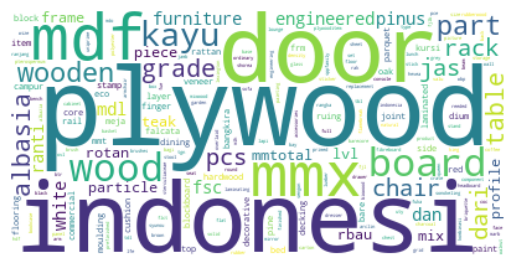

In [13]:
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(' '.join(temp_res))
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Feature Engineering

In [14]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=5, token_pattern='(\S+)')
tf_idf_matrix = tfidf_vectorizer.fit_transform(data['filtered_text'])
print(tf_idf_matrix)

  (0, 4023)	0.2557859595920206
  (0, 247)	0.3297424508682438
  (0, 8123)	0.32963584285329006
  (0, 4059)	0.3205764147288979
  (0, 12934)	0.25636755071903095
  (0, 1005)	0.3224805437188622
  (0, 9678)	0.21371578598531832
  (0, 4016)	0.25409500402766433
  (0, 238)	0.23982030789117964
  (0, 8122)	0.22790125663007835
  (0, 4049)	0.24462717228810013
  (0, 12931)	0.2491231608002453
  (0, 1003)	0.32109209969658997
  (1, 10673)	0.23930580094271278
  (1, 17311)	0.24485414121842808
  (1, 17081)	0.2626004434731937
  (1, 13706)	0.2626004434731937
  (1, 1264)	0.23174254178611067
  (1, 1119)	0.22777501617088658
  (1, 10754)	0.24485414121842808
  (1, 2393)	0.24485414121842808
  (1, 1124)	0.22235388534096956
  (1, 17228)	0.18028940032998114
  (1, 10661)	0.1724874462320325
  (1, 17304)	0.18871333503276122
  :	:
  (209836, 9678)	0.25245184386613084
  (209837, 13768)	0.4120119973222488
  (209837, 8538)	0.3678832561299393
  (209837, 7932)	0.3657928505990334
  (209837, 8533)	0.3075844538498575
  (209837, 5

## Similarity Scoring

In [15]:
def AwesomeCossimTop(A, B, ntop, lower_bound=0):
    # force A and B as a CSR matrix.
    # If they have already been CSR, there is no overhead
    A = A.tocsr()
    B = B.tocsr()
    M, _ = A.shape
    _, N = B.shape
 
    idx_dtype = np.int32
 
    nnz_max = M*ntop
 
    indptr = np.zeros(M+1, dtype=idx_dtype)
    indices = np.zeros(nnz_max, dtype=idx_dtype)
    data = np.zeros(nnz_max, dtype=A.dtype)
    ct.sparse_dot_topn(
            M, N, np.asarray(A.indptr, dtype=idx_dtype),
            np.asarray(A.indices, dtype=idx_dtype),
            A.data,
            np.asarray(B.indptr, dtype=idx_dtype),
            np.asarray(B.indices, dtype=idx_dtype),
            B.data,
            ntop,
            lower_bound,
            indptr, indices, data)
    return csr_matrix((data,indices,indptr),shape=(M,N))


t1 = time.time()

# adjust lower bound: 0.8
# keep top 10 similar results
matches = AwesomeCossimTop(tf_idf_matrix, tf_idf_matrix.transpose(), 10, 0.8)

t = time.time()-t1
print("finished in:", t)

finished in: 65.08625221252441


In [16]:
def GetMatchesDF(sparse_matrix, name_vector, top=100):
    non_zeros = sparse_matrix.nonzero()
    
    sparserows = non_zeros[0]
    sparsecols = non_zeros[1]
    
    if top:
        nr_matches = top
    else:
        nr_matches = sparsecols.size
    
    left_side = np.empty([nr_matches], dtype=object)
    right_side = np.empty([nr_matches], dtype=object)
    similairity = np.zeros(nr_matches)
    
    for index in range(0, nr_matches):
        left_side[index] = name_vector[sparserows[index]]
        right_side[index] = name_vector[sparsecols[index]]
        similairity[index] = sparse_matrix.data[index]
    
    return pd.DataFrame({'RINCIAN_BARANG': left_side,
                          'SIMILAR_RINCIAN_BARANG': right_side,
                           'similarity_score': similairity})
  
  
  
matches_df = pd.DataFrame()
matches_df = GetMatchesDF(matches, data['filtered_text'], top=10000)


# Remove all exact matches
matches_df = matches_df[matches_df['similarity_score'] < 0.99999] 
matches_df.sort_values("similarity_score")

,RINCIAN_BARANG,SIMILAR_RINCIAN_BARANG,similarity_score
3285,albasia bare core grade size cfr shangha china,albasia bare core grade size mmx mmx cfr shang...,0.800165
3284,albasia bare core grade size cfr shangha china,albasia bare core grade size mmx mmx cfr shang...,0.800165
3283,albasia bare core grade size cfr shangha china,albasia bare core grade size mmx mmx cfr shang...,0.800165
223,teak wood bed headboard bed headboard for twin...,teak wood bed headboard bed king,0.800864
224,teak wood bed headboard bed headboard for twin...,teak wood bed headboard bed king,0.800864
...,...,...,...
4856,indonesi plywood mmt jas sticker paper slip fsc,plywood mmt jas sticker paper slip fsc,0.980621
4854,indonesi plywood mmt jas sticker paper slip fsc,plywood mmt jas sticker paper slip fsc,0.980621
4855,indonesi plywood mmt jas sticker paper slip fsc,plywood mmt jas sticker paper slip fsc,0.980621
7730,teak fjl flooring oil coatingsize mmsize,teak fjl flooring oil coatingsize mmsize mmx,0.987719
